# Application 2: Two body single channel nuclear scattering

Contributed by: Daniel Odell, Pablo Giuliani.

We have the following Hamiltonian as the radial part of the scattering equation:
\begin{equation}
    F_\alpha(\phi)=\left(-\frac{d^2}{dr^2}+\frac{\ell(\ell+1)}{r^2}+U(r,\alpha)-p^2\right)\phi(r)=0,
\end{equation}
where a system with reduced mass $\mu$ interacts through a potential $V(r,\alpha)=U(r,\alpha)/2\mu$ with parameters $\alpha$, $\ell$ is the angular momentum quantum number, and $p$ is the asymptotic linear momentum. Using an optical potential for $V(r,\alpha)$ this equation could model, for example, how neutrons interact with nuclei as we explained in the introduction section:
<img src="Fig1Scatt.png" alt="Fig. 1" style="width:350px;height:200px;">


We can re-scale this equation with the changes of variables $s=pr$ making it possible for us to apply the RBM across energies. We obtain the following equation:

\begin{equation}
    \left(-\frac{d^2}{ds^2}+\frac{\ell(\ell+1)}{s^2}+\tilde U(s,\alpha,p)-1\right)\phi_\alpha(s)=0,
\end{equation}
where the potential $\tilde U(s,\alpha,p)=V(s/p,\alpha)2\mu/p^2$ is now momentum dependent. We now proceed to construct a high fidelity solver for this equation which we will use to build a Reduced Basis using Principal Component Analysis, and later project with the Galerkin equaitons. As a first implementation, we will use the [Minnesota potential](https://linkinghub.elsevier.com/retrieve/pii/0375947477900070):

\begin{equation}
U(r,V_{0R},V_{0S})=2\mu\left(V_{0R}e^{-1.487r^2}+ V_{0S}e^{-0.465r^2}\right),
\end{equation}

where the parameters are $\alpha=[V_{0R},V_{0S}]$. We have kept the non-linear parameter dependence of the potential (the coefficients multiplying $r^2$ on the exponentials) fixed on their original values. We will vary them in the next section when we explore the Empirical Interpolation Method (see chapter V of [this book](https://link.springer.com/book/10.1007/978-3-319-22470-1)). We also work with the S wave ($l=0$) in this example.


In [2106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# plt.style.use('science')

#Defining a couple of aesthetic parameters
gr = (1 + np.sqrt(5)) / 2
h = 3

In [2107]:
hbarc = 197 # MeV • fm
mass = 939 # MeV
energy = 50 # center-of-mass scattering energy, fixed for the first example
k = np.sqrt(mass*energy)/hbarc
l = 0 # S waves

# interaction parameters we will use for testing
v0r = 200
v0s = -91.85

def mn_potential(r, args):
    '''
    Minnesota potential
    '''
    v_0r, v_0s = args
    return v_0r * np.exp(-1.487*r**2) + v_0s*np.exp(-0.465*r**2)


def mn_potential_tilde(s, args):
    '''
    Energy-scaled Minnesota potential
    s = rho = kr
    '''
    return 1/energy * mn_potential(s/k, args)


## High fidelity solver

In [2108]:
initial_conditions = np.array([0.0, 1.0]) # initial phi(0) and phi'(0) conditions
s_endpts = k * np.array([1e-6, 20]) # dimensionless

s_mesh = np.linspace(*s_endpts, 2000)


def solve_se(theta):
    result = solve_ivp(
        lambda s, phi: np.array([phi[1],
            (mn_potential_tilde(s, theta) + l*(l+1)/s**2 - 1.0) * phi[0]]),
        s_endpts, initial_conditions, rtol=1e-12, atol=1e-12, dense_output=True
    )
    phi = result.sol(s_mesh)[0, :]
#     c = np.max(np.abs(phi))
#     return s_mesh, phi/c
    return s_mesh, phi

The figure above shows the high-fidelity solution, obtained by numerically integrating the initial conditions from $r=0$.

## Training the Reduced Basis

In [2109]:
#We create 10 random values of the linear parameters and solve the high fidelity problem 10 times

training_points = np.array([
    [119.51219512195122, -14.634146341463415],
    [139.02439024390245, -4.878048780487805],
    [158.53658536585365, -48.78048780487805],
    [178.0487804878049, -117.07317073170732],
    [197.5609756097561, -131.70731707317074],
    [217.0731707317073, -126.82926829268293],
    [236.58536585365854, -82.92682926829268],
    [256.0975609756098, -175.609756097561],
    [275.609756097561, -19.51219512195122],
    [295.1219512195122, -170.73170731707316]
])

training_solutions = np.array(
    [solve_se(theta)[1] for theta in training_points]
).T


And this is how they all look like:

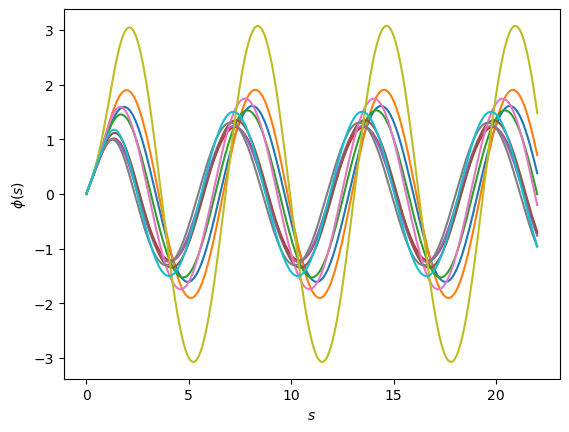

In [2110]:
fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')

for u in training_solutions.T:
    ax.plot(s_mesh, u)

ax.set_ylabel(r'$\phi(s)$')
ax.set_xlabel(r'$s$');

Lets go for a Principal Component Analysis/Singular Value Decomposition

In [2111]:
U, S, Vt = np.linalg.svd(training_solutions, full_matrices=False)

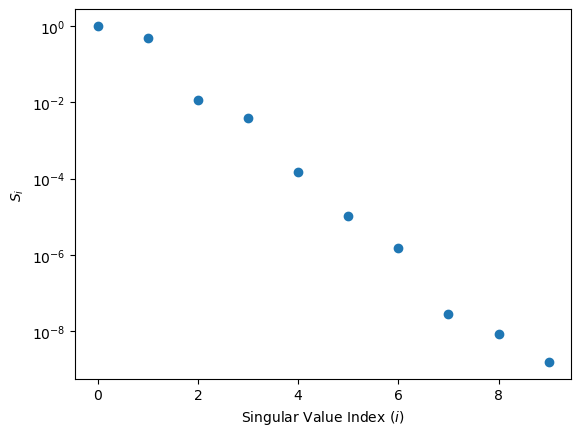

In [2112]:
fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')

ax.scatter(np.arange(S.size), S/S[0])

ax.set_yscale('log')
ax.set_xlabel(r'Singular Value Index ($i$)')
ax.set_ylabel(r'$S_i$');

The singular values indeed decay exponentially, indicating that a RBM emulation is probable to be succesful. It is interesting to note that the second singular value is higher than what one might initially expect. This is because outside of the potential region, the solution can be expressed in general as a linear combination of two orthogonal independent functions (related to sines and cosines), which is why in this case the second component is particularly important. The overall pattern of the singular value has this zig-zag (or stairs) pattern because of this reason.

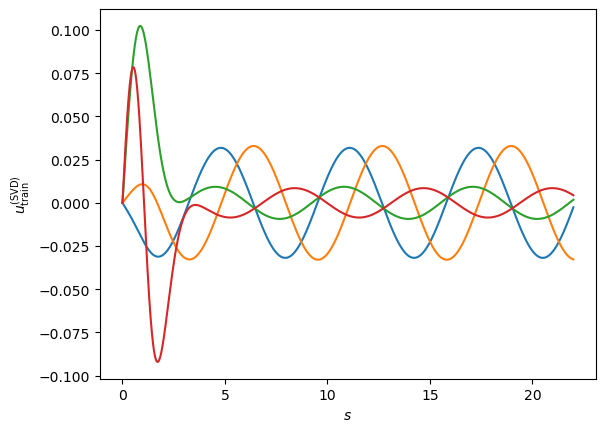

In [2113]:
#We select four basis and obtain the following gorgeous functions:
nbasis = 4

fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')

for i in range(nbasis):
    ax.plot(s_mesh, U[:, i])

ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$u_{\rm train}^{({\rm SVD})}$');

Very interestingly, if we were to now use this as our reduced basis, our projection equations will give us the solution constantly equal to zero $\hat \phi(r) =0$ and $a_k=0$. The reason is that the scattering problem is homogeneous in the function $\phi$ (the function zero is a valid solution). To get around this, we could impose a boundary condition, for example the asymptotic normalizations used in similar emulator papers (see [this one](https://www.sciencedirect.com/science/article/pii/S0370269320305220) and [this one](https://www.sciencedirect.com/science/article/pii/S0370269321007176)). 

Another way around it is to use the $\phi_0$ component avaialble in the RB expansion (look [here](https://arxiv.org/abs/2203.05284v2) for details):

\begin{equation}
    \phi \approx \hat\phi = \phi_0 + \sum_k^n a_k \phi_k
\end{equation}

We follow this approach by selecting $\phi_0$ as the free solution in the abscence of any potential. We re-define our principal components as the differences between this free solution and the high fidelity solutions for the different parameter values.

In [2114]:
phi_0 = solve_se(np.array([0, 0]))[1]

training_solutions_sub = np.zeros_like(training_solutions.T)

for i in range(training_solutions.shape[1]):
    training_solutions_sub[i,:] = training_solutions.T[i,:].copy() - phi_0
    



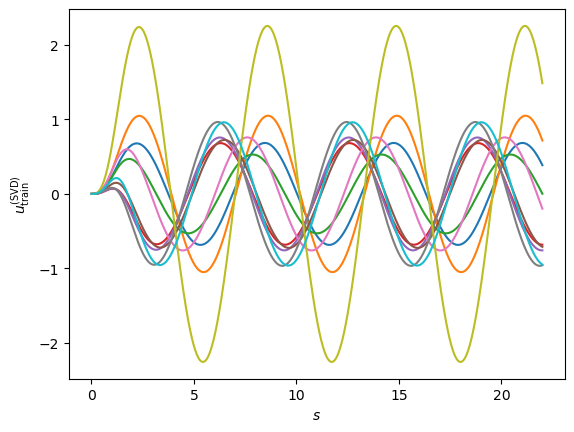

In [2115]:
fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')

for i in range(len(training_solutions_sub)):
    ax.plot(s_mesh, training_solutions_sub[i,:])

ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$u_{\rm train}^{({\rm SVD})}$');

In [2116]:
U, S, Vt = np.linalg.svd(training_solutions_sub.T, full_matrices=False)

In [2117]:
utilde = mn_potential_tilde(s_mesh, [v0r, v0s])[:, np.newaxis]

In [2118]:
basis = U[:, :nbasis] # Galerkin basis
psi = U[:, :nbasis] # judges
d2 = np.gradient(np.gradient(basis, s_mesh, axis=0), s_mesh, axis=0) # second derivative

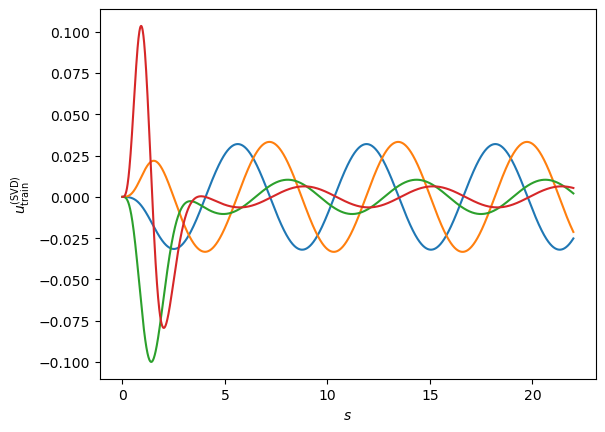

In [2119]:
fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')

for i in range(nbasis):
    ax.plot(s_mesh, basis[:,i])

ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$u_{\rm train}^{({\rm SVD})}$');

Now our new RB has by construction a zero derivative at $s=0$, the normalization condition of $\phi'(s=0)=1$ is entirely carried out by the $\phi_0$ term. Our Galerkin equations look like:

\begin{equation}
    \langle \psi_j | F(\hat\phi) \rangle = \langle \psi_j | F(\phi_0) \rangle + \sum_k ^n a_k\langle \psi_j | F(\phi_k) \rangle =0
\end{equation}

These $n$ ($j$ goes from 1 to $n$) equations can be written in a matrix form $Aa=b$, where $a=(a_1,a_2,...a_n)$, the matrix $A$ is form by the inner products between the projectors $\langle\psi_k|$ and the operator $F_\alpha$ acting on each one of the basis $|\phi_k\rangle$, and $b$ is the non-homogenous term obtaining from the projection of $F_\alpha(\phi_0)$ onto the $\psi_j$. This last term acts, in some sense, as a "source" for creating the non-homogenous solution to the approximated differential scattering equation through $F_\alpha$, which has information on the parameters $\alpha$.

Lets put all this into code and solve for the coefficients!

In [2120]:
A_right = -d2 + utilde * basis - basis
A = psi.T @ A_right
b = -psi.T @ (-np.gradient(np.gradient(phi_0, s_mesh), s_mesh) + utilde.T[0]*phi_0 - phi_0)
a = np.linalg.solve(A, b)
emu = np.sum(a * basis, axis=1)+phi_0

In [2121]:
a

array([ 2.97232314, 16.30316717,  0.35056666, -0.02741656])

In [2122]:
exact = solve_se([v0r, v0s])[1]

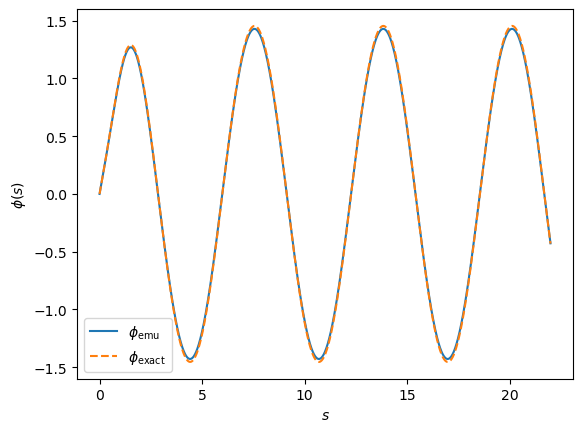

In [2123]:
fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')

ax.plot(s_mesh, emu, linestyle='-', label=r'$\phi_{\rm emu}$')
ax.plot(s_mesh, exact, linestyle='--', label=r'$\phi_{\rm exact}$')

ax.set_xlabel(r'$s$')
ax.set_ylabel(r'$\phi(s)$')
ax.legend();

Looks gorgeous doesn't it?

Now, there are many extensions we can explore to the approach we just did. In the following two sections we explore how to "linearize" the potential $V_\alpha$ when the dependence on the parameters is non-linear through the Empirical Interpolation Method. This will also allow us to emulating the solutions across different energies, since the dependence of the re-scaled potential in the energy is non-linear.

## Empirical Interpolation Method for a non-affine parameter in a potential

Let's consider the following potential with Woods-Saxon form:

\begin{equation}
    V(r;R,a) = -\frac{V_0}{1 + \exp{\frac{r-R}{a}}}.
\end{equation}

We would like to vary $R$, $a$, and/or the momentum; $p$. For now, let's focus our attention on just $R$. First, let's apply the scaling. We now have:

\begin{equation}
  U(s,p;S,z) = -\frac{ 2 \mu V_0 }{ p^2}  \frac{1}{ (1 + \exp{ \frac{s-S}{ z }})},
\end{equation}

where we've defined $S = R p$ and $z = a p$.

Notice how our parameters of interest are distincively non-affine; for example: $U(s,p; S + S', \tilde{a}) \neq U(s,p; S, \tilde{a}) + U(s,p; S', \tilde{a})$. If we want to construct an RBM with which we can perturb $S \rightarrow S'$, we will not be able to simply construct an affine space of scattering wavefunctions with a set of training points $T = \{ S_1, S_2, ..., S_N \}$ as before. Unless perhaps we could find an approximation of $U$ (let's call it $\tilde{U}$), that was affine in $S$ ...

\begin{equation}
U(s; S)  \approx \tilde{U}(s; S)  = \sum_k^M \beta_k(S) U_k(s) 
\end{equation}

... yeah, something like that! Here, we denote $U_k(s,p)$ as a "snapshot", or training point, of $U(s; S)$, evaluated at particular values $S = S_k$ ($z$ and $p$ will be fixed, so we will suppress dependence upon them going forward). $\tilde{U}(s;S)$ should interpolate $U(s;S)$ between the training points $T$.

Already, we see an analogy with what we did before in the space of wavefunctions, but now in the space of operators $U(s;S)$: we will evaluate $N$ snapshots of $U(s;S)$, with $S$ evaluated at each value on the training space $T$, which we are free to choose. As before, we will then do PCA to find $M < N$ dimensions that suitably encapsulate the information content of $U(s;S)$ as we vary $S \in T$. 

Then, we can simply plug our $M$ snapshots, $U_k(s)$ into the equation that enforces our desired interpolation:

\begin{equation}
U(s; S) = \sum_k^M \beta_k(S) U_k(s).
\end{equation}

We'll maybe not so simply, but we'll burn that bridge when we get to it. For now, let's build our training space.

First, define our potentials:

In [2124]:
def woods_saxon(r, args):
    V0, R, a = args
    return -V0/(1. + np.exp((r-R)/a))
    
def woods_saxon_tilde(s, args):
    V0, R, a = args
    return 1./energy * woods_saxon(s/k, (V0, R, a))

# interaction parameters we will use for testing
V0 = 200 # MeV
a  = 0.5 # fm

In [2125]:
# create N random points, distributed evenly, on our desired range
# it is inexpensive to simply evaluate a potential, so might as well 
# use a large number of training points
N = 1000

# logarithmically evenly
def generate_rand_log(log_min, log_max, N=40):
    return np.sort(np.exp( np.random.rand(N) * (log_max - log_min) + log_min ))

# linearly evenly
def generate_rand_lin(lin_min, lin_max, N=40):
    return np.sort(np.random.rand(N) * (lin_max - lin_min) + lin_min)

# let's take a physical range
R_min = 1
R_max = 6
T = np.arange(R_min, R_max, (R_max - R_min)/N) 
#T = generate_rand_log(np.log(R_min), np.log(R_max), N=N)

In [2126]:
def Utrain(s):
    """
    Takes in an array of s values, spits out a matrix of the Woods-Saxon reduced potential
    evaluated at those s and each S value on T
    """
    #TODO this is hacky af
    tmp = np.zeros(np.outer(s,T).shape)
    TT = tmp + T 
    SS = tmp.T + s
    return np.array([ woods_saxon_tilde(SS.T, (V0, TT, a)) ])[0].T

In [2127]:
r = np.arange(0,10, 1E-2)
s = r*k
Umat = Utrain(s)


Text(0, 0.5, '$U$ [a.u.]')

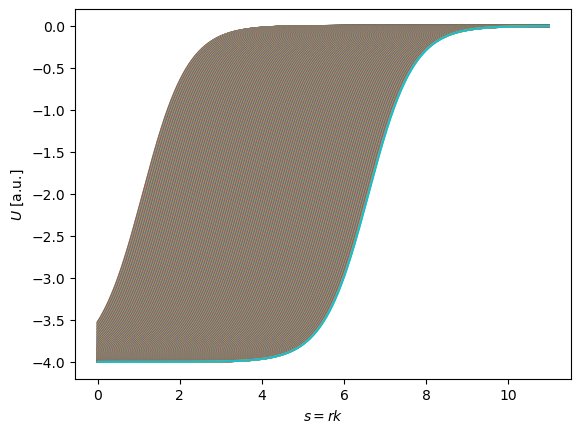

In [2128]:
for i in range(N):
    plt.plot(s, Umat[i,:])
plt.xlabel(r"$s = r k$")
plt.ylabel(r"$U$ [a.u.]")
#plt.show()


Great, we have a healthy training set of potentials. We would expect that the diffraction minima in differential elastic scattering cross sections, for example, to be quite sensitive to the $R$ value of a Woods-Saxon potential. In other words, all those potentials would produce very different cross-sections! Now let's do PCA and keep just the few that encapsulate most of this information.


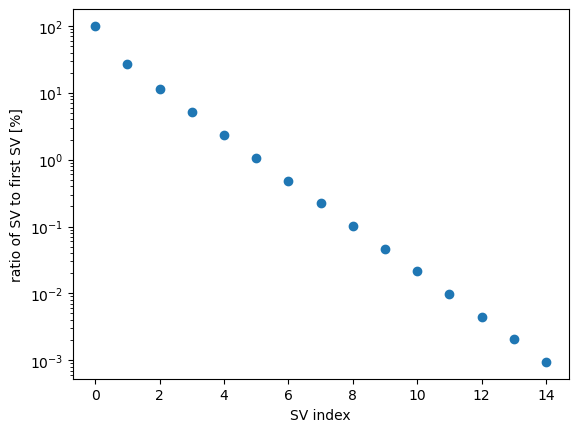

In [2129]:
# how big is our final basis?
U, S, Vt = np.linalg.svd(Umat.T, full_matrices=False)
plt.semilogy(100*S[:15]/S[0], "o", linestyle="None")
plt.xlabel("SV index")
plt.ylabel("ratio of SV to first SV [%]")
plt.show()

These singular values are dropping nicely; let's take only the first few. 

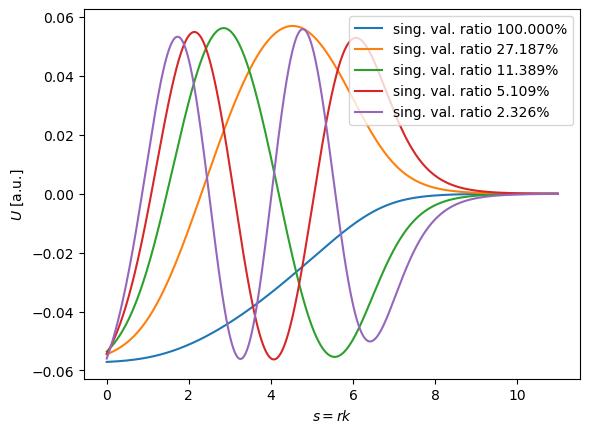

In [2140]:
M = 5 # definitely less than N!
for i in range(M):
    plt.plot(s, U[:,i], label="sing. val. ratio {:1.3f}%".format(100*S[i]/S[0]))
plt.xlabel(r"$s = r k$")
plt.ylabel(r"$U$ [a.u.]")
plt.legend()
plt.show()

Great, we have our basis $U_k(s)$. We only need 4 elements to represent most of the information encapsulated in our training set! Now we would like to determine our $M$ coefficients, $\beta_k(S)$. If we evaluate the interpolation equation at $M$ values of $s$, we have $M$ equations, which pairs quite nicely with out $M$ unknown coefficients. But what values of $s$ should we choose? 

Intuitively, we should choose the $s$ values which provide the most information - the places where the variance in potential values between the different parameters is highest. Let's take a look at the standard deviation of our training set as a function of $s$:

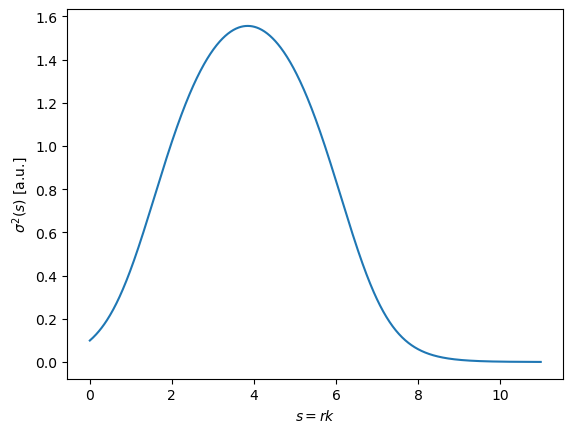

In [2141]:
plt.plot(s, np.sqrt(np.var(Umat, axis=0)) )
plt.xlabel(r"$s = r k$")
plt.ylabel(r"$\sigma^2(s)$ [a.u.]")
plt.show()

As a first pass, let's choose $M$ points, $s_k$, roughly sampled (by eye) this distribution, and simultaneously solve our interpolation equation at those points. There are certainly better ways to pick points - e.g. a greedy algorithm that chooses points in a correlated way, choosing the next point based on the variance remaining after choosing the previous points. We'll stick with our simple uncorrelated method for now - we can always refine later.

In [2142]:
#TODO sampling scheme is very high variance for small M
#TODO add greedy algo
ps = np.sqrt(np.var(Umat, axis=0))

# normalize
ps /= np.trapz(ps, x=s)
ps /= np.sum(ps)

sample_pts = np.random.choice(s, size=M, p=ps)

In [2143]:
sample_pts


array([6.54438044, 2.43076988, 5.20250747, 5.38948977, 1.31987505])

We know want to solve an equation of the form

\begin{equation}
\mathbf{A} \overline{x}(S) = \overline{b}(S),
\end{equation}

where 

\begin{equation}
{b}_{j} = U(s_j,S),
\end{equation}
and 
\begin{equation}
{A}_{jk} = U_j(s_k),
\end{equation}

and our unkown coefficient functions,
\begin{equation}
{x}_{k} = \beta_k(S).
\end{equation}

In [2144]:
A = np.zeros((M,M))
for j in range(M):
    A[:,j] = np.interp( sample_pts, s, U[:,j])

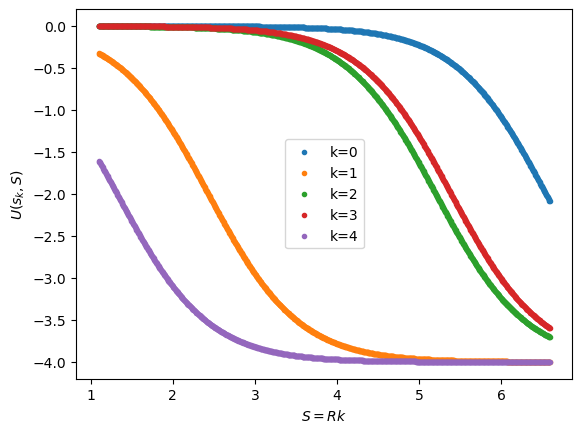

In [2145]:
b = np.zeros((M,N))
for ki in range(M):
    b[ki,:] = woods_saxon_tilde(sample_pts[ki], (V0, T, a))
    plt.scatter(k*T, woods_saxon_tilde(sample_pts[ki], (V0, T, a)), 
                marker='.', label="k={}".format(ki))
plt.xlabel(r"$S = R k$")
plt.ylabel(r"$U(s_k,S)$")
plt.legend()
plt.show()

In [2146]:
# solve the system to find the coefficient functions
x = np.einsum('jk,k...', np.linalg.inv(A), b)

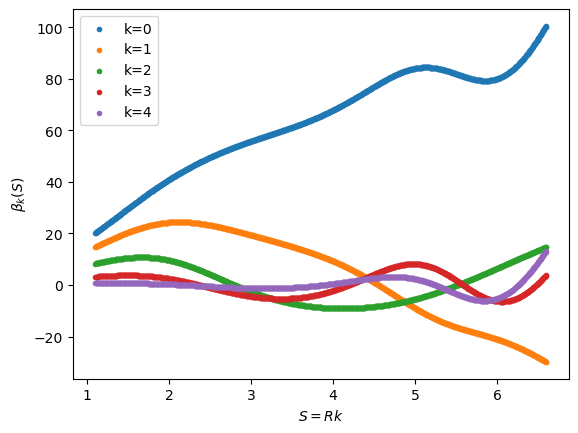

In [2147]:
for j in range(M):
    plt.scatter(k*T, x[:,j],  marker='.', label="k={}".format(j))
plt.xlabel(r"$S = Rk$")
plt.ylabel(r"$\beta_k(S)$")
plt.legend()
plt.show()

Intuitively, we see that the coefficients generally decrease in magnitude with the singular value, which is a good sanity check. Now let's put it all together to test our affine decomposition of the potential.

In [2148]:
def ws_affine_decomp(s, args, R_grid):
    '''
    affine decomposition of our Woods-Saxon potential
    '''
    V0, R, a = args
    S = R*k
    
    betas = np.zeros(M)
    Uad   = np.zeros_like(s)

    for i in range(M):
        betas[i] = np.interp(S, k*R_grid, x[:,i])
        Uad += betas[i] * U[:,i]
    print(betas)
    return Uad

[31.97168197 21.52633635 10.72196382  3.71661684  0.6777209 ]


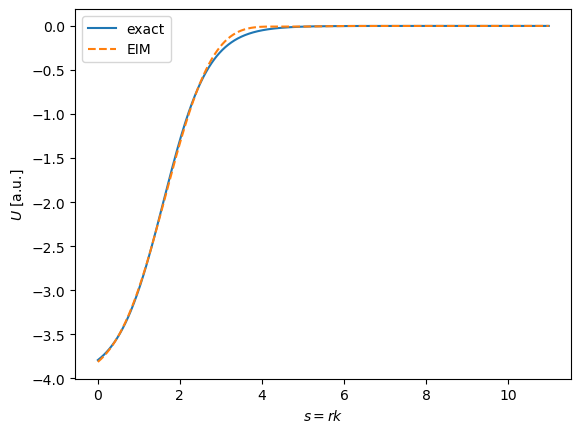

In [2151]:
R_test = 1.45
plt.plot(s, woods_saxon_tilde(s, (V0, R_test, a)),  label="exact")
plt.plot(s, ws_affine_decomp(s, (V0, R_test, a), T), '--', label="EIM")

plt.xlabel(r"$s = r k$")
plt.ylabel(r"$U$ [a.u.]")
plt.legend()
plt.show()

Nice.